In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [59]:
aq=pd.read_hdf("air_quality_data.h5",key ='data')

In [60]:
from data_transformation import obtener_registros_por_hora
from scipy.interpolate import griddata
def generate_interpolations(dataframe):
    fecha_hora_unicas = dataframe['fecha'].unique()
    interpolations = []

    for date_time in fecha_hora_unicas:
        df_hora = obtener_registros_por_hora(dataframe, date_time)

        lat = df_hora['latitud']
        lon = df_hora['longitud']
        aqi = df_hora['aqi']

        longitud_grid = np.linspace(lon.min(), lon.max(), 100)
        latitud_grid = np.linspace(lat.min(), lat.max(), 100)
        longitud_mesh, latitud_mesh = np.meshgrid(longitud_grid, latitud_grid)

        grid_interpolado_cubico = griddata((lon, lat), aqi, (longitud_mesh, latitud_mesh), method='cubic')
        puntos_faltantes = np.isnan(grid_interpolado_cubico)
        grid_interpolado_vecinos = griddata((lon, lat), aqi, (longitud_mesh, latitud_mesh), method='nearest')
        grid_interpolado_combinado = np.where(puntos_faltantes, grid_interpolado_vecinos, grid_interpolado_cubico)

        interpolations.append(grid_interpolado_combinado)

    return interpolations


In [61]:
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
from data_transformation import obtener_registros_por_hora

def generate_interpolation_dataframe(dataframe):
    fecha_hora_unicas = dataframe['fecha'].unique()
    interpolations = []

    for date_time in fecha_hora_unicas:
        df_hora = obtener_registros_por_hora(dataframe, date_time)

        lat = df_hora['latitud']
        lon = df_hora['longitud']
        aqi = df_hora['aqi']

        longitud_grid = np.linspace(lon.min(), lon.max(), 100)
        latitud_grid = np.linspace(lat.min(), lat.max(), 100)
        longitud_mesh, latitud_mesh = np.meshgrid(longitud_grid, latitud_grid)

        grid_interpolado_cubico = griddata((lon, lat), aqi, (longitud_mesh, latitud_mesh), method='cubic')
        puntos_faltantes = np.isnan(grid_interpolado_cubico)
        grid_interpolado_vecinos = griddata((lon, lat), aqi, (longitud_mesh, latitud_mesh), method='nearest')
        grid_interpolado_combinado = np.where(puntos_faltantes, grid_interpolado_vecinos, grid_interpolado_cubico)

        interpolations.append(grid_interpolado_combinado)

    interpolation_df = pd.DataFrame({
        "fecha": fecha_hora_unicas,
        "interpolacion": interpolations
    })

    return interpolation_df


In [62]:
interpolations_df=generate_interpolation_dataframe(aq)

In [63]:
def calculate_daily_interpolation_means(dataframe):
    # Crear una lista para almacenar los datos de salida
    daily_means = []

    for index, row in dataframe.iterrows():
        # Obtener la fecha y la matriz de interpolación
        date = row['fecha']
        interpolation_matrix = row['interpolacion']

        # Calcular el promedio de la matriz de interpolación
        mean_interpolation = np.mean(interpolation_matrix)

        # Almacenar la fecha y el promedio en la lista de resultados
        daily_means.append([date, mean_interpolation])

    # Crear un DataFrame a partir de la lista de resultados
    daily_mean_df = pd.DataFrame(daily_means, columns=['fecha', 'promedio_interpolacion'])
    daily_mean_df = daily_mean_df.groupby(daily_mean_df['fecha'].dt.date).mean()
    return daily_mean_df



In [64]:
df_daily_means = calculate_daily_interpolation_means(interpolations_df)

In [65]:
#df_daily_means.to_hdf("daily_contamination.h5", key='data', format='table', mode='w')


In [66]:
def fechas_con_promedio_mayor_a_100(df):
    fechas_superior_a_100 = df[df['promedio_interpolacion'] > 100]['fecha'].tolist()
    return fechas_superior_a_100


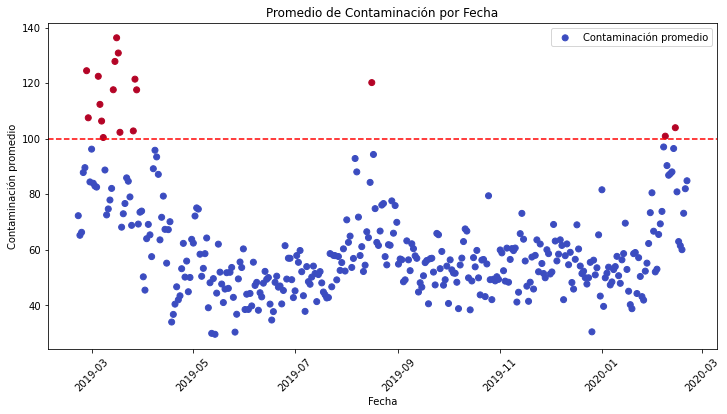

In [67]:
plt.figure(figsize=(12, 6))
plt.scatter(df_daily_means.index, df_daily_means['promedio_interpolacion'], c=df_daily_means['promedio_interpolacion'] > 100, cmap='coolwarm', label='Contaminación promedio')
plt.xlabel('Fecha')
plt.ylabel('Contaminación promedio')
plt.title('Promedio de Contaminación por Fecha')
plt.legend()
plt.xticks(rotation=45)
plt.axhline(y=100, color='red', linestyle='--', label='Umbral 100')
plt.show()


In [72]:
df_daily_means = df_daily_means.reset_index()


In [77]:
filtro = df_daily_means["promedio_interpolacion"]>100
dias_altos = df_daily_means[filtro]

In [98]:
from dateutil import parser

print("Se recomienda pico y placa en la ciudad de Medellín durante los siguientes días, debido a que presentan un promedio")
print("de contaminación AQI mayor a 100, lo cual es perjudicial para la salud de la población")
print()
df = pd.DataFrame(dias_altos)


for index, row in df.iterrows():
    date_str = str(row['fecha']) 
    date = parser.parse(date_str)
    print(date.strftime("%A %d de %B de %Y"))


Se recomienda pico y placa en la ciudad de Medellín durante los siguientes días, debido a que presentan un promedio
de contaminación AQI mayor a 100, lo cual es perjudicial para la salud de la población

Tuesday 26 de February de 2019
Wednesday 27 de February de 2019
Tuesday 05 de March de 2019
Wednesday 06 de March de 2019
Thursday 07 de March de 2019
Friday 08 de March de 2019
Thursday 14 de March de 2019
Friday 15 de March de 2019
Saturday 16 de March de 2019
Sunday 17 de March de 2019
Monday 18 de March de 2019
Tuesday 26 de March de 2019
Wednesday 27 de March de 2019
Thursday 28 de March de 2019
Friday 16 de August de 2019
Saturday 08 de February de 2020
Friday 14 de February de 2020
